In [1]:
import os
import random
import ujson
from rlagents import MCAgent, QLAgent, benchmark
import seaborn as sns
import pandas as pd
from tqdm import tqdm_notebook, tqdm
%matplotlib inline

## TuringLearner
Can a Reinforcement Agent learn to perform right shift using a Turing Machine?

Turing machines represent a powerful class of computing machines. The Human input to those machines is that part of the machine which contains it's 'programming'. Namely the part which says what action to take.

In [2]:
from rlagents import __version__
__version__

(0, 0, 12)

In [3]:
actions = ['<', '>', 'r', 'w', 'stop']
agent_list = [QLAgent(actions)]
print(agent_list)

[<QLearner>]


In [4]:
class TuringWorld:
    def __init__(self, iogen):
        self.iogen = iogen
        self.reset()
    
    def reset(self):
        self.inp, self.out = self.iogen()
        self.out_tape = list(self.out)
        
        self.tape = list(self.inp)
        self.rlimit = len(self.tape) - 1
        self.head = 0
        self.cache = '0'
        return [self.tape[self.head], self.cache, self.head]
    
    def copy(self):
        t = TuringWorld(self.iogen)
        t.tape = self.tape
        t.head = self.head
        t.cache = self.cache
        t.inp, t.out = self.inp, self.out
        t.out_tape = self.out_tape
        return t

    def step(self, act):
        done = False
        rew = 0
        if act == '<':
            self.head = max(0, self.head - 1)
        elif act == '>':
            self.head = min(self.head + 1, self.rlimit)
        elif act == 'r':
            self.cache = self.tape[self.head]
        elif act == 'w':
            self.tape[self.head] = self.cache
        elif act == 'stop':
            done = True
            rew = sum([i==j for i, j in zip(self.out_tape, self.tape)]) / len(self.out_tape)
        return [self.tape[self.head], self.cache, self.head], rew ,done, None

In [5]:
def divbytwogen():
    a = int(random.random()*100)
    b = a // 2
    a, b = bin(a)[2:], bin(b)[2:]
    return a, b
world_list = [TuringWorld(divbytwogen)]

## Running bench

In [6]:
!rm -rf DataDir/

In [7]:
paths = benchmark(agent_list, world_list, 1000, None, 2000)

DataDir does not exist. Creating...
Building Dispatch list...
Running experiments...


100%|██████████| 2000/2000 [00:15<00:00, 115.40it/s]


Experiments completed...


In [8]:
paths = ['DataDir/'+i for i in os.listdir('DataDir/')]
data = []
for p in tqdm(paths, leave=False):
    with open(p, 'r') as fl:
        da = ujson.load(fl)
        
        x = [(None, 'Monte' in d[1], None, int(d[3]), float(d[4]), int(d[5]))
             for d in da]
        data.extend(x)

## Result Plotting

In [9]:
data = pd.DataFrame(data, columns=['runid', 'agent', 'world', 'ep', 'rew', 'trial'])
data.agent = 'Q Learning'

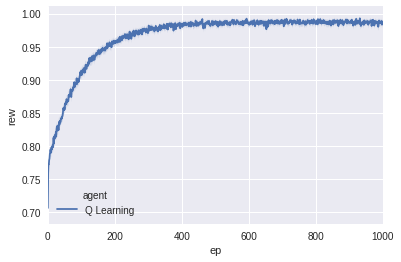

In [12]:
sns.tsplot(data, time='ep', value='rew', unit='trial', condition='agent', ci=95)

In [11]:
!rm -rf DataDir/